In [33]:
import json, os,re
import pandas as pd
import  matplotlib.pyplot as plt


## Prep Workspace

In [34]:

directory = os.getcwd()+'/'
logname = 'roymartinez.dev.har'
domain = 'roymartinez.dev'

FirstParty = ['roymartinez.dev']
if not os.path.isdir(directory+'/Output/'):
    os.mkdir(directory+'/Output/')

In [35]:
with open(directory+'Logs/'+logname, 'r') as f:
    har = json.loads(f.read())
    f.close()


## Helper Function

In [36]:
def findHeader(req,headertype,headername,op = None):
    value = "None"
    if headertype == 'response':
        for h in req['response']['headers']:
            if op == 'in':
                if headername in h['name']:
                    value = h['value']
                    break
            else:
                if headername == h['name']:
                    value = h['value']
                    
                    break
    if headertype == 'cdn-timing':
        value = 0
        for h in req['response']['headers']:
            if op == 'eq':
                if 'server-timing' in h['name']:
                    if headername in h['value']:
                        
                        value = int(h['value'].split(';')[1].split('=')[1])
                        break
        if value is None:
            return 0
    return value

## Extract and Clean Data

In [50]:
colmms = ['url','host','host-type','method','status','ext','cpcode','ttl','server','cdn-cache','cdn-cache-parent','cdn-cache-key','cdn-req-id','vary','appOrigin','content-length','content-length-origin','blocked','dns','ssl','connect','send','ttfb','receive','edgeTime','originTime'
]
dat_clean = pd.DataFrame(columns=colmms)
for r in har['log']['entries']:
    u = str(r['request']['url']).split('?')[0]
    host = re.search('://(.+?)/', u, re.IGNORECASE).group(0).replace(':','').replace('/','')
    
    cachekey = str(findHeader(r,'response','x-cache-key','eq'))
    if not cachekey == 'None':
        cachekey = cachekey.split('/')
        cpcode = int(cachekey[3])
        ttl = cachekey[4]
        cdnCache = str(findHeader(r,'response','x-cache','eq')).split(' ')[0]
        cdnCacheParent = str(findHeader(r,'response','x-cache-remote','eq')).split(' ')[0]
        origin = str(findHeader(r,'response','x-cache-key','eq')).split('/')[5]
    else:
        cachekey = "None"
        cpcode = "None"
        ttl = "None"
        cdnCache = "None"
        cdnCacheParent = "None"
        origin = "None"

    ext = re.search(r'(\.[A-Za-z0-9]+$)', u, re.IGNORECASE)
    if any(tld in host for tld in FirstParty):
        hostType = 'First Party'
    else:
        hostType = 'Third Party'
    
    if ext is None:
        ext = "None"
    else:
        ext = ext.group(0).replace('.','') 
    ct = findHeader(r,'response','content-length','eq')
    if ct == "None":
        ct = 0
    else:
        ct = int(ct)
    if ext in ['jpg','png']:
        ct_origin = findHeader(r,'response','x-im-original-size','eq')
    else:
        ct_origin = findHeader(r,'response','x-akamai-ro-origin-size','eq')
    if ct_origin == "None":
        ct_origin = 0
    else:
        ct_origin = int(ct_origin)
    new_row = {
        'url':u,
        'host':host,
        'host-type':hostType,
        'method':r['request']['method'],
        'status':r['response']['status'],
        'ext':ext,
        'cpcode':cpcode,
        'ttl':ttl,
        'server':str(findHeader(r,'response','server','eq')),
        'cdn-cache':cdnCache,
        'cdn-cache-parent':cdnCacheParent,
        'cdn-cache-key':str(findHeader(r,'response','x-true-cache-key','eq')),
        'cdn-req-id':str(findHeader(r,'response','x-akamai-request-id','eq')),
        'vary':str(findHeader(r,'response','vary','eq')),
        'appOrigin':origin,
        'content-length':ct,
        'content-length-origin':ct_origin,
        'blocked':r['timings']['blocked'],
        'dns':r['timings']['dns'],
        'ssl':r['timings']['ssl'],
        'connect':r['timings']['connect'],
        'send':r['timings']['send'],
        'ttfb':r['timings']['wait'],
        'receive':r['timings']['receive'],
        'edgeTime':findHeader(r,'cdn-timing','edge','eq'),
        'originTime':findHeader(r,'cdn-timing','origin','eq')
        
        }

    dat_clean = dat_clean.append(new_row,ignore_index=True)


dat_clean = dat_clean.groupby(colmms).size().reset_index(name='Count')   
  
dat_clean.to_csv(directory+'Output/output.csv',index=False)   


## General Examples

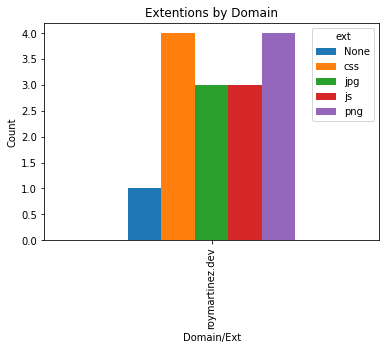

In [38]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'First Party']
tmp = tmp.groupby(['host','ext']).size().reset_index(name='Count') 
tmp = tmp.reset_index().pivot(columns='ext', index='host', values='Count')
tmp.plot.bar();
plt.title('Extentions by Domain')
plt.xlabel('Domain/Ext')
plt.ylabel('Count')
plt.show()

del tmp  

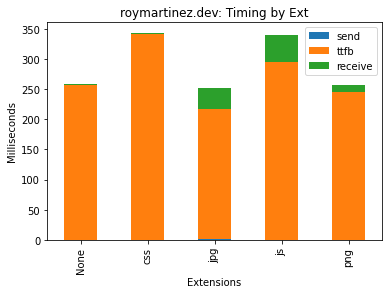

In [39]:
tmp = dat_clean
tmp =  tmp[tmp['host'] == domain]
tmp = tmp.groupby('ext')[ "send", "ttfb", "receive"].mean().reset_index()
tmp[["ext", "send", "ttfb", "receive"]].plot(x="ext", kind="bar", stacked=True,label='Series')
plt.title(domain+': Timing by Ext')
plt.xlabel('Extensions')
plt.ylabel('Milliseconds')
plt.show()
del tmp  

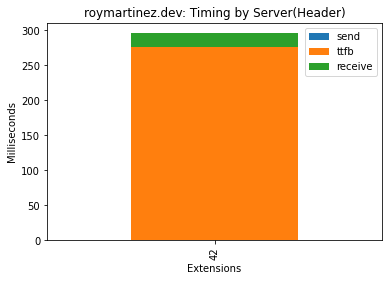

In [61]:
tmp = dat_clean
tmp =  tmp[tmp['host'] == domain]
tmp = tmp.groupby('server')[ "send", "ttfb", "receive"].mean().reset_index()
tmp[["server", "send", "ttfb", "receive"]].plot(x="server", kind="bar", stacked=True,label='Series')
plt.title(domain+': Timing by Server(Header)')
plt.xlabel('Extensions')
plt.ylabel('Milliseconds')
plt.show()
del tmp  



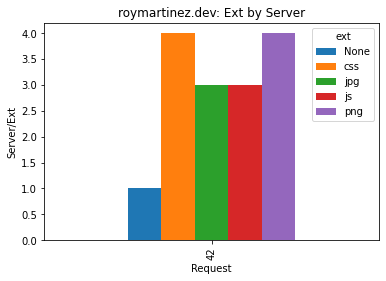

In [41]:
tmp = dat_clean
tmp =  tmp[tmp['host'] == domain]
tmp = tmp.groupby(['server','ext'])['server','ext'].size().reset_index(name='Count') 
tmp = tmp.reset_index().pivot(columns='ext', index='server', values='Count')
tmp.plot.bar();
plt.title(domain+': Ext by Server(Header)')
plt.xlabel('Request')
plt.ylabel('Server/Ext')
plt.show()

del tmp

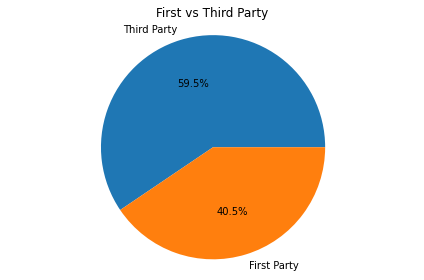

In [42]:
tmp = dat_clean 
tmp = tmp.groupby(['host','host-type','url']).size().reset_index(name='Count')
tmp = tmp.groupby(['host-type']).sum().reset_index()
tmp = tmp.sort_values(by=['Count'],ascending=False)
   
#https://chrisalbon.com/python/data_visualization/matplotlib_pie_chart/
plt.pie(tmp['Count'],labels=tmp['host-type'],shadow=False,autopct='%1.1f%%')
plt.title('First vs Third Party')
plt.axis('equal')
plt.tight_layout()
# plt.savefig(directory+'/Output/'+account+'/First_vs_ThirdParty.jpg')
plt.show()

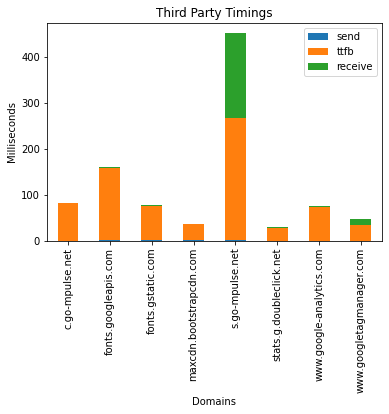

In [43]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'Third Party']
tmp = tmp.groupby('host')[ "send", "ttfb", "receive"].mean().reset_index()
tmp[["host", "send","ttfb", "receive"]].plot(x="host", kind="bar", stacked=True,label='Series')
plt.title('Third Party Timings')
plt.xlabel('Domains')
plt.ylabel('Milliseconds')
plt.show()
del tmp

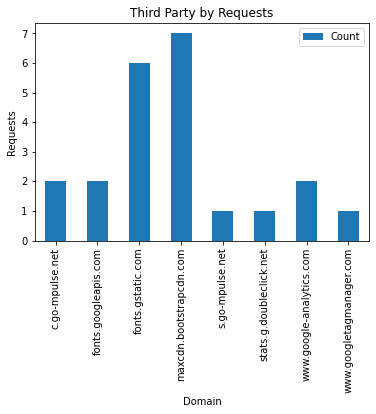

In [44]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'Third Party']
tmp = tmp.groupby('host').size().reset_index(name='Count').plot(x="host", kind="bar", stacked=True,label='Series')
plt.title('Third Party by Requests')
plt.xlabel('Domain')
plt.ylabel('Requests')
plt.show()
del tmp


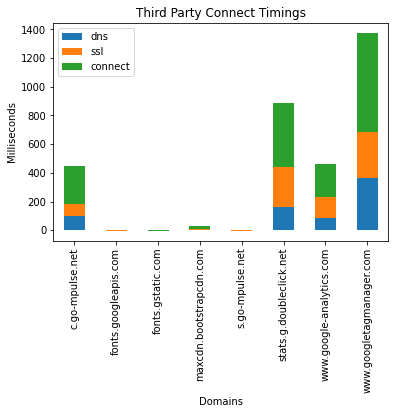

In [45]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'Third Party']
tmp = tmp.groupby('host')[ "dns","ssl","connect"].mean().reset_index()
tmp[["host", "dns","ssl","connect"]].plot(x="host", kind="bar", stacked=True,label='Series')
plt.title('Third Party Connect Timings')
plt.xlabel('Domains')
plt.ylabel('Milliseconds')
# plt.savefig(directory+'/Output/'+account+'/ThirdParty_timings.jpg')
plt.show()
del tmp

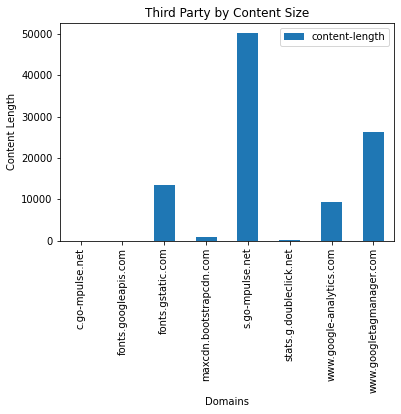

In [46]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'Third Party']
tmp = tmp.groupby('host')[ "content-length"].mean().reset_index()
tmp[["host", "content-length"]].plot(x="host", kind="bar", stacked=True,label='Series')
plt.title('Third Party by Content Size')
plt.xlabel('Domains')
plt.ylabel('Content Length')
plt.show()
del tmp

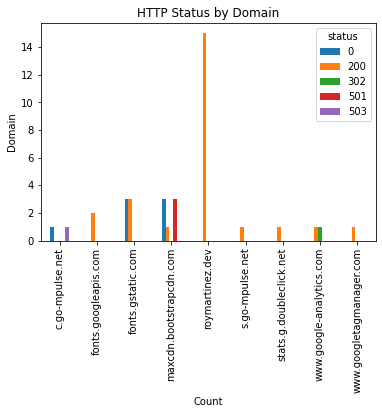

In [47]:
tmp = dat_clean
tmp = tmp.groupby(['host','status']).size().reset_index(name='Count') 
tmp = tmp.reset_index().pivot(columns='status', index='host', values='Count')
tmp.plot.bar();
plt.title('HTTP Status by Domain')
plt.xlabel('Count')
plt.ylabel('Domain')
plt.show()
del tmp


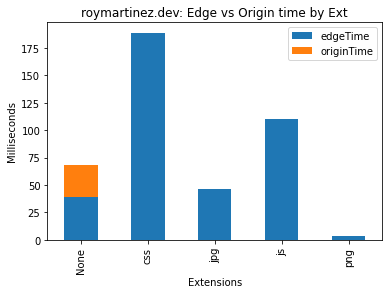

In [48]:
tmp = dat_clean
tmp =  tmp[tmp['host'] == domain]
tmp = tmp.groupby('ext')[ "edgeTime", "originTime"].mean().reset_index()
tmp[["ext", "edgeTime", "originTime"]].plot(x="ext", kind="bar", stacked=True,label='Series')
plt.title(domain+': Edge vs Origin time by Ext')
plt.xlabel('Extensions')
plt.ylabel('Milliseconds')
plt.show()
del tmp  

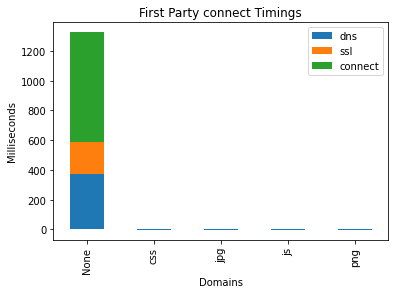

In [49]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'First Party']
tmp = tmp.groupby('ext')["dns","ssl","connect"].mean().reset_index()
tmp[["ext", "dns","ssl","connect"]].plot(x="ext", kind="bar", stacked=True,label='Series')
plt.title('First Party connect Timings')
plt.xlabel('Domains')
plt.ylabel('Milliseconds')
# plt.savefig(directory+'/Output/'+account+'/ThirdParty_connect_timings.jpg')
plt.show()
del tmp

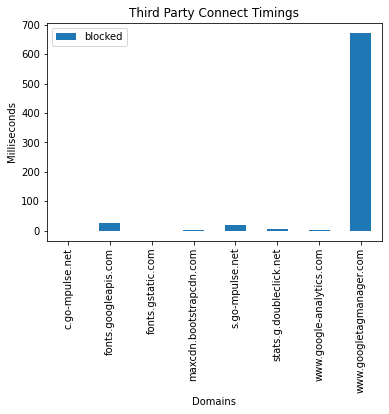

In [51]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'Third Party']
tmp = tmp.groupby('host')[ "blocked"].mean().reset_index()
tmp[["host", "blocked"]].plot(x="host", kind="bar", stacked=True,label='Series')
plt.title('Third Party Connect Timings')
plt.xlabel('Domains')
plt.ylabel('Milliseconds')
# plt.savefig(directory+'/Output/'+account+'/ThirdParty_timings.jpg')
plt.show()
del tmp

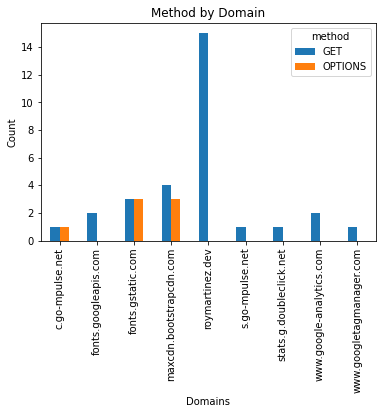

In [52]:
tmp = dat_clean
tmp = tmp[["host","method"]]
tmp = tmp.groupby(['host','method']).size().reset_index(name='Count') 
tmp = tmp.reset_index().pivot(columns='method', index='host', values='Count')
tmp.plot.bar();
plt.title('Method by Domain')
plt.xlabel('Domains')
plt.ylabel('Count')
plt.show()
del tmp

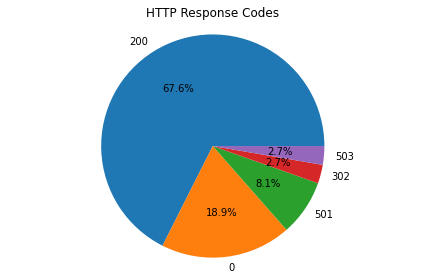

In [53]:
tmp = dat_clean 
tmp = tmp.groupby(['status']).size().reset_index(name='Count')
tmp = tmp.sort_values(by=['Count'],ascending=False)
plt.pie(tmp['Count'],labels=tmp['status'],shadow=False,autopct='%1.1f%%')
plt.title('HTTP Response Codes')
plt.axis('equal')
plt.tight_layout()
plt.show()

## Akamai Section

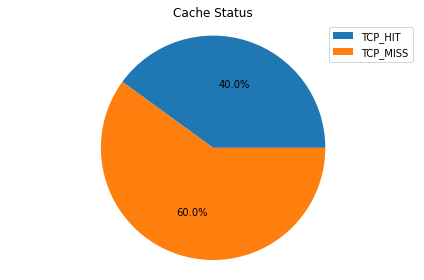

In [54]:
tmp = dat_clean 
tmp =  tmp[tmp['host'] == domain]
tmp = tmp.groupby(['cdn-cache']).size().reset_index(name='Count')
plt.pie(tmp['Count'],shadow=False,autopct='%1.1f%%')
plt.legend( tmp['cdn-cache'], loc="best")
plt.title('Cache Status')
plt.axis('equal')
plt.tight_layout()
plt.show()

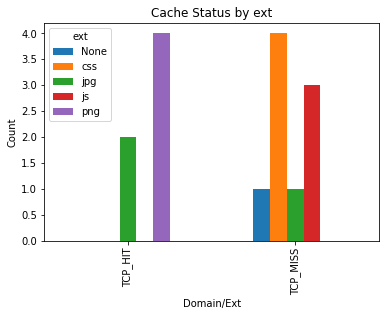

In [55]:
tmp = dat_clean
tmp =  tmp[tmp['host'] == domain]
tmp = tmp.groupby(['cdn-cache','ext']).size().reset_index(name='Count') 
tmp = tmp.reset_index().pivot(columns='ext', index='cdn-cache', values='Count')
tmp.plot.bar();
plt.title('Cache Status by ext')
plt.xlabel('Domain/Ext')
plt.ylabel('Count')
plt.show()

del tmp  

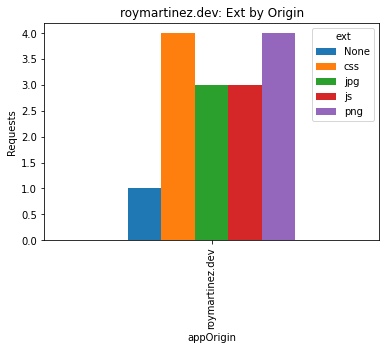

In [56]:
tmp = dat_clean
tmp =  tmp[tmp['host-type'] == 'First Party']
tmp =  tmp[tmp['host'] == domain]
tmp =  tmp[tmp['appOrigin'] != None]
tmp =  tmp[tmp['appOrigin'] != "None"]
tmp = tmp.groupby(['appOrigin','ext']).size().reset_index(name='Count') 
tmp = tmp.reset_index().pivot(columns='ext', index='appOrigin', values='Count')
tmp.plot.bar();
plt.title(domain+': Ext by Origin')
plt.xlabel('appOrigin')
plt.ylabel('Requests')
# plt.savefig(directory+'/Output/'+account+'/'+domain+'_Ext_by_Origin.jpg')
plt.show()
del tmp


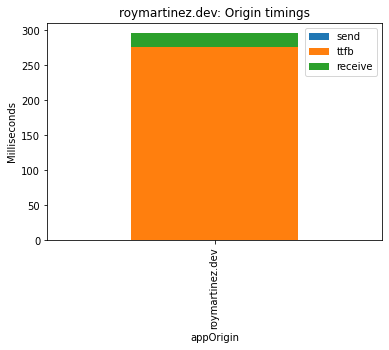

In [57]:
tmp = dat_clean
tmp =  tmp[tmp['host'] == domain]
tmp = tmp.groupby('appOrigin')[ "send", "ttfb", "receive"].mean().reset_index()
tmp[["appOrigin", "send","ttfb", "receive"]].plot(x="appOrigin", kind="bar", stacked=True,label='Series')
plt.title(domain+': Origin timings')
plt.xlabel('appOrigin')
plt.ylabel('Milliseconds')
# plt.savefig(directory+'/Output/'+account+'/'+domain+'_Origin_timings.jpg')
plt.show()
del tmp

In [58]:

tmp = dat_clean
tmp =  tmp[tmp['vary'] != "None"]
tmp =  tmp[tmp['vary'] != "Accept-Encoding"]
tmp =  tmp[tmp['host-type'] == 'First Party']
tmp = tmp.groupby(['url','vary']).size().reset_index(name='Count')

display(tmp.head())
  

,url,vary,Count


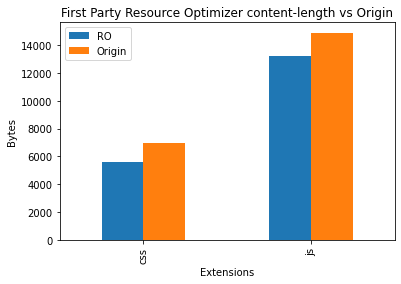

In [59]:
tmp = dat_clean
tmp = tmp[tmp['host-type'] == 'First Party']
tmp = tmp[tmp['ext'].isin(['css','js'])]
tmp = tmp.groupby('ext')["content-length","content-length-origin"].mean().reset_index()
tmp[["ext", "content-length","content-length-origin"]].plot(x="ext", kind="bar",label=['RO','RAW'])
plt.title('First Party Resource Optimizer content-length vs Origin')
plt.xlabel('Extensions')
plt.ylabel('Bytes')
plt.legend(["RO", "Origin"]);
plt.show()
del tmp

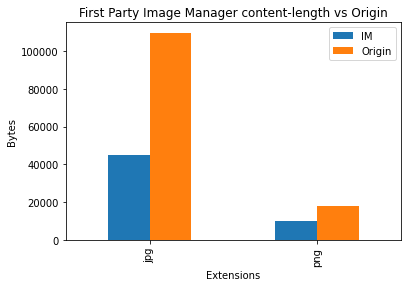

In [60]:
tmp = dat_clean
tmp = tmp[tmp['host-type'] == 'First Party']
tmp = tmp[tmp['ext'].isin(['jpg','png'])]
tmp = tmp.groupby('ext')["content-length","content-length-origin"].mean().reset_index()
tmp[["ext", "content-length","content-length-origin"]].plot(x="ext", kind="bar",label=['RO','RAW'])
plt.title('First Party Image Manager content-length vs Origin')
plt.xlabel('Extensions')
plt.ylabel('Bytes')
plt.legend(["IM", "Origin"]);
plt.show()
del tmp